#### Yolov5 Cervical Spine (Neck) Fracture Detection
by @vbookshelf<br>
10 August 2022


## Task

Train a Yolov5 computer vision model to automatically detect fractures on cervical spine (neck) CT scans.

**Input:** CT scans of cervical vetebrae in png format.<br>
**Output:** Bounding box coordinates, and a score that indicates the probability that a fracture is present.

This model does not identify the vertebrae where the fracture is present i.e. predictions are only for the patient_overall class.

## Data

The competition training data consists of 2019 patient scans. Each scan contains multiple cervical spine CT images (slices) in dicom format. There are 7217 images that have bounding boxes that identify the location of fractures.

To create the training set I chose all images that have bounding boxes. I also randomly selected 1000 images that do not have bounding boxes i.e. no fracture is present. I converted all dicom images to png format without resizing - Yolov5 automatically resizes images during training. I set aside 20% of all images for validation, stratified by class (0 = normal, 1 = fracture).

In summary, in this notebook there are 6573 train images and 1644 validation images. Taining and validation images are in png format.

I converted the training images from dicom to png format and stored them in a Kaggle dataset (spine-fracture-comp-data). It's attached to this notebook.


## Approach

- Use Yolov5l
- Use png images with the resize parameter set to 512
- Use image augmentation to reduce overfitting and improve the model's ability to generalize to unseen data.
- Train for 80 epochs

## Results

Fracture detection using computer vision is possible. A comparison of true and predicted bounding boxes is displayed in this notebook. A confusion matrix and classification report is also provided. Click this link to go straight to the training and validation review: <a href='#validation_review'>Training and Validation Review</a><br>

## Learning Resources

- If you are new to Yolov5 then you may find the following tutorial helpful. It explains step by step how Yolov5 works.<br>
https://www.kaggle.com/code/vbookshelf/basics-of-yolo-v5-balloon-detection

- If you want to build a web app to perform cervical spine fracture detection, this example may be helpful:<br>
https://github.com/vbookshelf/COVID-19-CXR-Analyzer

In [1]:
import pandas as pd
import numpy as np
import os


import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader

#from tqdm import tqdm

# tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
import tqdm.notebook as tq
#for i in tq.tqdm(...):


import gc


import albumentations as albu
from albumentations import Compose


from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, jaccard_score
import itertools


# load image with Pillow
from PIL import Image

from numpy import asarray

from skimage.transform import resize


import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

1.12.1+cu102
0.13.1+cu102


In [2]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [8]:
os.listdir('/home/nvr5386/Desktop/RSNA/project_data/RSNA')

['train_bounding_boxes.csv',
 'newtrain',
 'test_images',
 'metadata',
 'cervical-fracture-detection',
 'test.csv',
 'train_images',
 'sample_submission.csv',
 'segmentations',
 'train.csv']

In [15]:
base_path = '/home/nvr5386/Desktop/RSNA/project_data/RSNA/'

prep_data_path = '/home/nvr5386/Desktop/RSNA/project_data/'


## Config

In [6]:
# Yolo setup:
NUM_EPOCHS = 80
BATCH_SIZE = 32
IMAGE_SIZE = 512 # Yolo will automatically resize the input images to this size.

# This is the fold that Yolo is trained on
CHOSEN_FOLD = 0

NUM_FOLDS = 5

NUM_CORES = os.cpu_count()
NUM_CORES

16

## Set up Yolov5 - For offline use

The Yolov5 model being used here needs to have the internet turned for training to work. However, it does not need to have the internet on during inference.

In [9]:
# Copy the yolov5 folder from the notebook to  /kaggle/working/

#shutil.copytree('../input/d/vbookshelf/v2-balloon-detection-dataset/yolov5', '/kaggle/working/yolov5')

#shutil.copytree('../input/my-yolov5-for-offline-use/yolov5', '/kaggle/working/yolov5')

FileNotFoundError: [Errno 2] No such file or directory: '../input/my-yolov5-for-offline-use/yolov5'

In [13]:
!ls

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
archive.zip
df_data.csv
image.png
images_dir
models
nohup.out
pytorch-effnetv2-vertebrae-detection-acc-0-95.ipynb
RSNA
rsna-fracture-detection-in-depth-eda.ipynb
segeffnetv2-f0
submission.csv
testmodel.tph
yolov5
yolov5-cervical-spine-neck-fracture-detection.ipynb


## Load the train data

In [16]:
path = prep_data_path + 'df_data.csv'

df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head()

(8217, 9)


,StudyInstanceUID,patient_id,fname,slice_number,h,w,path,study_slice,label
0,1.2.826.0.1.3680043.10678,10678,120.dcm,120,512,512,../input/rsna-2022-cervical-spine-fracture-det...,1.2.826.0.1.3680043.10678_120,1
1,1.2.826.0.1.3680043.10678,10678,165.dcm,165,512,512,../input/rsna-2022-cervical-spine-fracture-det...,1.2.826.0.1.3680043.10678_165,1
2,1.2.826.0.1.3680043.10678,10678,124.dcm,124,512,512,../input/rsna-2022-cervical-spine-fracture-det...,1.2.826.0.1.3680043.10678_124,1
3,1.2.826.0.1.3680043.10678,10678,71.dcm,71,512,512,../input/rsna-2022-cervical-spine-fracture-det...,1.2.826.0.1.3680043.10678_71,1
4,1.2.826.0.1.3680043.10678,10678,131.dcm,131,512,512,../input/rsna-2022-cervical-spine-fracture-det...,1.2.826.0.1.3680043.10678_131,1


In [17]:
df_data['label'].value_counts()

1    7217
0    1000
Name: label, dtype: int64

## Process the train data

In [18]:
# Create a column called 'target'

df_data['target'] = list(df_data['label'])

#df_data.head()

In [19]:
# Targets:
# 0 = normal
# 1 = fracture

df_data['target'].value_counts()

1    7217
0    1000
Name: target, dtype: int64

## Create a column for the bbox info

In [20]:
# Load the bbox data

# This dataframe lists all slides that have fractures

path = base_path + 'train_bounding_boxes.csv'
df_bbox = pd.read_csv(path)

print(df_bbox.shape)

df_bbox.head()

(7217, 6)


,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


In [21]:
def create_study_slice(row):
    
    study_id = str(row['StudyInstanceUID'])
    slice_num = str(row['slice_number'])
    
    study_slice = study_id + '_' + slice_num
    
    return study_slice

df_bbox['study_slice'] = df_bbox.apply(create_study_slice, axis=1)

df_bbox = df_bbox.set_index('study_slice')

print(df_bbox.shape)

df_bbox.head()

(7217, 6)


,StudyInstanceUID,x,y,width,height,slice_number
study_slice,,,,,,
1.2.826.0.1.3680043.10051_133,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051_134,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051_135,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051_136,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051_137,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


In [22]:
# Put the bbox info for each image into a list of bbox dicts

# Note: According to df_bbox we only have one bbox per image (slice)

study_slice_list = list(df_data['study_slice'])

bbox_list = []

for i in range(0, len(df_data)):
    
    target = df_data.loc[i, 'target']
    study_slice = df_data.loc[i, 'study_slice']
    
    if target == 1:
    
        x = df_bbox.loc[study_slice, 'x']
        y = df_bbox.loc[study_slice, 'y']
        width = df_bbox.loc[study_slice, 'width']
        height = df_bbox.loc[study_slice, 'height']

        bbox_dict ={
            'x': x,
            'y': y,
            'width': width,
            'height': height
        }

        bbox_list.append(bbox_dict)
        
    else:
        bbox_list.append('none')
        
        
# Add the bbox_list to df_data

df_data['boxes'] = bbox_list

#print(df_data.shape)

#df_data.head()

In [23]:
df_data.head(2)

,StudyInstanceUID,patient_id,fname,slice_number,h,w,path,study_slice,label,target,boxes
0,1.2.826.0.1.3680043.10678,10678,120.dcm,120,512,512,../input/rsna-2022-cervical-spine-fracture-det...,1.2.826.0.1.3680043.10678_120,1,1,"{'x': 230.0, 'y': 198.0, 'width': 72.0, 'heigh..."
1,1.2.826.0.1.3680043.10678,10678,165.dcm,165,512,512,../input/rsna-2022-cervical-spine-fracture-det...,1.2.826.0.1.3680043.10678_165,1,1,"{'x': 222.08697, 'y': 227.06087, 'width': 103...."


In [24]:
# Display one entry

df_data.loc[0, 'boxes']

{'x': 230.0, 'y': 198.0, 'width': 72.0, 'height': 67.0}

## Helper functions

In [25]:
# Confusion matrix where the size of the plot and the text size can be changed

# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         text_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=text_size)
    plt.yticks(tick_marks, classes, fontsize=text_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=text_size)

    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)
    plt.tight_layout()

In [26]:
# Source: https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px

from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data




def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

## Create the folds

In [27]:
from sklearn.model_selection import KFold, StratifiedKFold

skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=101)

for fold, ( _, val_) in enumerate(skf.split(X=df_data, y=df_data.target)):
      df_data.loc[val_ , "fold"] = fold
        
df_data['fold'].value_counts()

0.0    1644
1.0    1644
4.0    1643
3.0    1643
2.0    1643
Name: fold, dtype: int64

In [28]:
# Display the target distribution in each fold

for fold_index in range(0, NUM_FOLDS):
    
    df_train = df_data[df_data['fold'] != fold_index]
    df_val = df_data[df_data['fold'] == fold_index]

    print(f'\nFold {fold_index}')
    print('.........')
    print()
    print('Train shape:',df_train.shape)
    print('Val shape:',df_val.shape)
    print()
    print('Train target distribution')
    print(df_train['target'].value_counts())
    print()
    print('Val target distribution')
    print(df_val['target'].value_counts())


Fold 0
.........

Train shape: (6573, 12)
Val shape: (1644, 12)

Train target distribution
1    5773
0     800
Name: target, dtype: int64

Val target distribution
1    1444
0     200
Name: target, dtype: int64

Fold 1
.........

Train shape: (6573, 12)
Val shape: (1644, 12)

Train target distribution
1    5773
0     800
Name: target, dtype: int64

Val target distribution
1    1444
0     200
Name: target, dtype: int64

Fold 2
.........

Train shape: (6574, 12)
Val shape: (1643, 12)

Train target distribution
1    5774
0     800
Name: target, dtype: int64

Val target distribution
1    1443
0     200
Name: target, dtype: int64

Fold 3
.........

Train shape: (6574, 12)
Val shape: (1643, 12)

Train target distribution
1    5774
0     800
Name: target, dtype: int64

Val target distribution
1    1443
0     200
Name: target, dtype: int64

Fold 4
.........

Train shape: (6574, 12)
Val shape: (1643, 12)

Train target distribution
1    5774
0     800
Name: target, dtype: int64

Val target distr

## Create the Yolo directory structure

We need to create a directory structure inside the yolov5 folder. This is where the training and validation data will need to be stored

In [29]:
# Note the the following folder structure must be
# located inside the yolov5 folder

# base_dir
    # images
        # train (contains image files)
        # validation (contains image files)
    # labels 
        # train (contains .txt files)
        # validation (contains .txt files)
        
# Yolo expects the bounding box dimensions to be
# normalized to have values between 0 and 1.
        
# Label format in .txt file
# class x-center y-center width height
# E.g. 0 0.1 0.2 200 300

# Each label is on a new line, in the .txt file:
# 0 0.1 0.2 200 300
# 0 0.1 0.2 200 300

In [39]:
# change the working directory to yolov5
os.chdir('/home/nvr5386/Desktop/RSNA/project_data/yolov5')

# Create a new directory (this is happening inside the yolov5 directory)

base_dir = 'base_dir'
#os.mkdir(base_dir)


# Now we create folders inside 'base_dir':

# base_dir

    # images
        # train
        # validation

    # labels
        # train
        # validation

# images
images = os.path.join(base_dir, 'images')
#os.mkdir(images)

# labels
labels = os.path.join(base_dir, 'labels')
#os.mkdir(labels)



# Inside each folder we create seperate folders for each class

# create new folders inside images
train = os.path.join(images, 'train')
#os.mkdir(train)
validation = os.path.join(images, 'validation')
#os.mkdir(validation)


# create new folders inside labels
train = os.path.join(labels, 'train')
#os.mkdir(train)
validation = os.path.join(labels, 'validation')
#os.mkdir(validation)

# Display the folder structure
!tree base_dir

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: line 1: tree: command not found


## Process the data

Here we will write a function to process the training and validation data. 

We need to create a separate txt file for each image that contains the details of all the bounding boxes on that image.  This function will also move the training and val data into the directory structure that we created above. We won't need to do any image resizing for Yolo. It will do that automatically during training.

In [40]:
# Change the working directory
os.chdir('/home/nvr5386/Desktop/RSNA/project_data/')

In [41]:
# Choose the fold to train on.

fold_index = CHOSEN_FOLD

df_train = df_data[df_data['fold'] != fold_index]
df_val = df_data[df_data['fold'] == fold_index]

print(df_train['target'].value_counts())
print(df_val['target'].value_counts())

1    5773
0     800
Name: target, dtype: int64
1    1444
0     200
Name: target, dtype: int64


In [42]:
# Iterate through each row in the dataframe

# We run the function below separately for
# the train and val sets.
# Remember that each image gets it's own text file
# containing the info for all bboxes on that image.

# For each image:
# 1- get the info for each bounding box
# 2- write the bounding box info to a txt file
# 3- save the txt file in the correct folder
# 4- copy the image to the correct folder

# Note on bboxes:
# For each image we have a list of dictionaries. Each dict 
# contains the coords one one bbox on that image.
# We don't need to do anything if the image does not have any bboxes.


def process_data_for_yolo(df, data_type='train'):

    for _, row in tq.tqdm(df.iterrows(), total=len(df)):
        
        # Get the target
        target = row['target']
        
        # Create the image file name
        study_slice = row['study_slice']
        fname = study_slice + '.png'
        
        
        # Only create txt files for class 1 images
        if target == 1:
        
            # Get the list of bboxes on the image.
            # Each item in the list is a dict containing the image coords.
            bbox_dict = row['boxes']
            
            # put the coords into a list
            bbox_list = [bbox_dict]
            
            # These are the original image sizes.
            # If we have resized the images then this must be changed to
            # the new sizes. We will then also be using resized bbox coords.
            image_width = row['w']
            image_height = row['h']


            # Convert into the Yolo input format
            # ...................................
            
            yolo_data = []

            # row by row
            for coord_dict in bbox_list:

                xmin = int(coord_dict['x'])
                ymin = int(coord_dict['y'])
                bbox_w = int(coord_dict['width'])
                bbox_h = int(coord_dict['height'])

                # We only have one class i.e. opacity
                # We will set the class_id to 0 for all images.
                # Class numbers must start from 0.
                class_id = target

                x_center = xmin + (bbox_w/2)
                y_center = ymin + (bbox_h/2)


                # Normalize
                # Yolo expects the dimensions to be normalized i.e.
                # all values between 0 and 1.

                x_center = x_center/image_width
                y_center = y_center/image_height
                bbox_w = bbox_w/image_width
                bbox_h = bbox_h/image_height

                # [class_id, x-center, y-center, width, height]
                yolo_list = [class_id, x_center, y_center, bbox_w, bbox_h]

                yolo_data.append(yolo_list)

            # convert to nump array
            yolo_data = np.array(yolo_data)


            # Write the image bbox info to a txt file
            #image_id = image_name.split('.')[0]
            np.savetxt(os.path.join('yolov5/base_dir', 
                        f"labels/{data_type}/{study_slice}.txt"),
                        yolo_data, 
                        fmt=["%d", "%f", "%f", "%f", "%f"]
                        ) # fmt means format the columns



        # Copy the image to images
        # Set the path to the images here.
        shutil.copyfile(
            f"{prep_data_path}/images_dir/{fname}",
            os.path.join('yolov5/base_dir', f"images/{data_type}/{fname}")
        )
        
        

# Call the function    
process_data_for_yolo(df_train, data_type='train')
process_data_for_yolo(df_val, data_type='validation')

  0%|          | 0/6573 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

In [43]:
!ls

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
archive.zip
df_data.csv
image.png
images_dir
models
nohup.out
pytorch-effnetv2-vertebrae-detection-acc-0-95.ipynb
RSNA
rsna-fracture-detection-in-depth-eda.ipynb
segeffnetv2-f0
submission.csv
testmodel.tph
yolov5
yolov5-cervical-spine-neck-fracture-detection.ipynb


In [44]:
# Check that the files have been created

print(len(os.listdir('yolov5/base_dir/images/train')))
print(len(os.listdir('yolov5/base_dir/images/validation')))

print(len(os.listdir('yolov5/base_dir/labels/train')))
print(len(os.listdir('yolov5/base_dir/labels/validation')))

6573
1644
5773
1444


In [45]:
text_file_list = os.listdir('yolov5/base_dir/labels/train')

text_file = text_file_list[0]

text_file

'1.2.826.0.1.3680043.19778_253.txt'

In [46]:
# Display the contents of a text file

! cat 'yolov5/base_dir/labels/train/1.2.826.0.1.3680043.26979_172.txt'

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
1 0.524414 0.633789 0.158203 0.154297


## Create the yaml file
Yolo requires that we also create a yaml file inside the yolov5 folder.

In [47]:
# Ref:
# Reading and Writing YAML to a File in Python
# https://stackabuse.com/reading-and-writing-yaml-to-a-file-in-python

yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
            'val': 'base_dir/images/validation', # path to the val folder
            'nc': 2,                             # number of classes
            'names': ['0', '1']}                # list of label names



# Create the yaml file called my_data.yaml
# We will save this file inside the yolov5 folder.

import yaml

with open(r'yolov5/my_data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [48]:
# Check that the my_data.yaml file is in the yolov5 folder.
# It should appear in the list of files.

os.listdir('yolov5')

['.github',
 '.git',
 'val.py',
 'setup.cfg',
 'LICENSE',
 '.dockerignore',
 'detect.py',
 'classify',
 'README.md',
 '.gitattributes',
 'utils',
 'CONTRIBUTING.md',
 'train.py',
 'hubconf.py',
 'segment',
 'data',
 'export.py',
 '.gitignore',
 'my_data.yaml',
 'requirements.txt',
 '.pre-commit-config.yaml',
 'base_dir',
 'CITATION.cff',
 'models',
 'benchmarks.py',
 'tutorial.ipynb']

In [49]:
# Display the contents of the yaml file

! cat 'yolov5/my_data.yaml'

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
names:
- '0'
- '1'
nc: 2
train: base_dir/images/train
val: base_dir/images/validation


## Create a custom hyperameter/augmentation yaml file

In [50]:
# Ref:
# Reading and Writing YAML to a File in Python
# https://stackabuse.com/reading-and-writing-yaml-to-a-file-in-python


yaml_dict = {
    
'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
'lrf': 0.032,  # final OneCycleLR learning rate (lr0 * lrf)
'momentum': 0.937,  # SGD momentum/Adam beta1
'weight_decay': 0.0005,  # optimizer weight decay 5e-4
'warmup_epochs': 3.0,  # warmup epochs (fractions ok)
'warmup_momentum': 0.8,  # warmup initial momentum
'warmup_bias_lr': 0.1,  # warmup initial bias lr
'box': 0.1,  # box loss gain
'cls': 1.0,  # cls loss gain
'cls_pw': 0.5,  # cls BCELoss positive_weight
'obj': 2.0,  # obj loss gain (scale with pixels)
'obj_pw': 0.5,  # obj BCELoss positive_weight
'iou_t': 0.20,  # IoU training threshold
'anchor_t': 4.0,  # anchor-multiple threshold
'anchors': 0,  # anchors per output layer (0 to ignore)
'fl_gamma': 0.0,  # focal loss gamma (efficientDet default gamma=1.5)
'hsv_h': 0,  # image HSV-Hue augmentation (fraction)
'hsv_s': 0,  # image HSV-Saturation augmentation (fraction)
'hsv_v': 0,  # image HSV-Value augmentation (fraction)
'degrees': 30.0,  # image rotation (+/- deg)
'translate': 0.2,  # image translation (+/- fraction)
'scale': 0.3,  # image scale (+/- gain)
'shear': 0.0,  # image shear (+/- deg)
'perspective': 0.0,  # image perspective (+/- fraction), range 0-0.001
'flipud': 0.2,  # image flip up-down (probability)
'fliplr': 0.5,  # image flip left-right (probability)
'mosaic': 0.8,  # image mosaic (probability)
'mixup': 0.0  # image mixup (probability)
    
}


# Create the yaml file called my_hyp.yaml
# We will save this file inside the yolov5 folder.

import yaml

with open(r'yolov5/my_hyp.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [51]:
# Check that the my_data.yaml file is in the yolov5 folder.
# It should appear in the list of files.

os.listdir('yolov5')

['.github',
 '.git',
 'val.py',
 'setup.cfg',
 'my_hyp.yaml',
 'LICENSE',
 '.dockerignore',
 'detect.py',
 'classify',
 'README.md',
 '.gitattributes',
 'utils',
 'CONTRIBUTING.md',
 'train.py',
 'hubconf.py',
 'segment',
 'data',
 'export.py',
 '.gitignore',
 'my_data.yaml',
 'requirements.txt',
 '.pre-commit-config.yaml',
 'base_dir',
 'CITATION.cff',
 'models',
 'benchmarks.py',
 'tutorial.ipynb']

In [52]:
# Display the contents of the  my_hyp.yaml file

! cat 'yolov5/my_hyp.yaml'

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
anchor_t: 4.0
anchors: 0
box: 0.1
cls: 1.0
cls_pw: 0.5
degrees: 30.0
fl_gamma: 0.0
fliplr: 0.5
flipud: 0.2
hsv_h: 0
hsv_s: 0
hsv_v: 0
iou_t: 0.2
lr0: 0.01
lrf: 0.032
mixup: 0.0
momentum: 0.937
mosaic: 0.8
obj: 2.0
obj_pw: 0.5
perspective: 0.0
scale: 0.3
shear: 0.0
translate: 0.2
warmup_bias_lr: 0.1
warmup_epochs: 3.0
warmup_momentum: 0.8
weight_decay: 0.0005


## Train the model

In [54]:
# change the working directory to yolov5
os.chdir('/home/nvr5386/Desktop/RSNA/project_data/yolov5/')

!pwd

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/nvr5386/Desktop/RSNA/project_data/yolov5


In [ ]:
# What some of the parameters mean:

# --weights => the pre-trained model that we are using.
# We are using weights that have been downloaded and stored in a Kaggle dataset.

# --save-txt => The predicted bbox coordinates get saved to a txt file. One txt file per image.
# --save-conf => The conf score gets included in the above txt file.
# --img => The image will be resized to this size before creating the mosaic.
# --conf => The confidence threshold
# --rect => Means don't use mosaic augmentation during training
# --name => Give a model a name e.g. --name my_model
# --batch => batch size
# --epochs => number of training epochs
# --data => the yaml file path
# --exist-ok => do not increment the project names with each run i.e. don't change exp to epx2, exp3 etc.
# --nosave => do not save the images/videos (helpful when deploying to a server)

# It's helpful to review the source code in detect.py to know what the above parameters mean.
# detect.py is located inside the yolov5 folder.

In [55]:
# Path to the weights stored in the dataset
#yolo_model_path = '/kaggle/input/my-yolov5-for-offline-use/yolov5l.pt'

# If you uncomment and run this line you will get a request to enter a 
# wandb password. To solve this problem we include WANDB_MODE="dryrun" in
# the next line.
! python train.py --img 1024 --batch 8 --epochs 2 --data my_data.yaml --cfg models/yolov5s.yaml --name my_model

# Note that now hyp=my_hyp.yaml in the printout blow.
!WANDB_MODE="dryrun" python train.py --img $IMAGE_SIZE --batch $BATCH_SIZE --epochs $NUM_EPOCHS --data my_data.yaml --hyp my_hyp.yaml --weights $yolo_model_path

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=my_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=8, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=my_model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yol

## Copy the trained model

We will copy the trained model to the Kaggle working directory. This will make the model easier to access.

In [57]:
# This is where the trained model is stored

path = '/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/my_model/weights/'

os.listdir(path)

['best.pt', 'last.pt']

In [58]:
# change the working directory
os.chdir('/home/nvr5386/Desktop/RSNA/project_data/')

!pwd

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/nvr5386/Desktop/RSNA/project_data


In [59]:
# Copy the best model to the kaggle/working

shutil.copyfile(
    '/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/my_model/weights/best.pt',
    '/home/nvr5386/Desktop/RSNA/project_data/best.pt')


!ls

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
archive.zip
best.pt
df_data.csv
image.png
images_dir
models
nohup.out
pytorch-effnetv2-vertebrae-detection-acc-0-95.ipynb
RSNA
rsna-fracture-detection-in-depth-eda.ipynb
segeffnetv2-f0
submission.csv
testmodel.tph
yolov5
yolov5-cervical-spine-neck-fracture-detection.ipynb


## Get the name of the last experiment

Yolov5 saves every training run as an experiment.

In [60]:
# change the working directory to yolov5
os.chdir('/home/nvr5386/Desktop/RSNA/project_data/yolov5')

!pwd

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/nvr5386/Desktop/RSNA/project_data/yolov5


In [85]:
os.listdir('/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/')

['my_model']

In [86]:
# get a list of experiments
exp_list = os.listdir('/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/')

exp_list

['my_model']

In [87]:
# Get the latest exp.
# I found that the first item in the list is the latest experiment. Not
# the last item as one would normally expect.
exp = exp_list[0]

exp

'my_model'

In [88]:
# Display the contents of the "exp" folder
os.listdir(f'/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/{exp}')

['R_curve.png',
 'P_curve.png',
 'confusion_matrix.png',
 'labels_correlogram.jpg',
 'val_batch2_pred.jpg',
 'val_batch1_pred.jpg',
 'train_batch2.jpg',
 'results.png',
 'val_batch0_labels.jpg',
 'results.csv',
 'weights',
 'val_batch2_labels.jpg',
 'val_batch0_pred.jpg',
 'opt.yaml',
 'events.out.tfevents.1670385563.h3wilkinson.293483.0',
 'train_batch0.jpg',
 'F1_curve.png',
 'hyp.yaml',
 'PR_curve.png',
 'train_batch1.jpg',
 'val_batch1_labels.jpg',
 'labels.jpg']

| <a id='validation_review'></a>

## Training and Validation Review

**Please look at the list of files in the output of the above cell.**

- Yolo stores all the training curves as one png file. To view the training curves we need to display the png file.

- **IMPORTANT NOTE:** The summary displayed at the end of training shows the resuts for the LAST epoch. This is not the results for the BEST epoch. The results for each epoch are logged in a file called results.txt. We will load that file into a pandas dataframe and then get the best epoch and the best mAP score.

- Yolo also stores png images showing the true and predicted labels for each val batch. In these images the true and predicted bounding boxes are drawn in. One batch is shown on one image.

There's more results info available. The yolov5 folder will appear in the output of this notebook. I suggest that you download it and look at the contents of the yolov5/runs/train/exp folder.

In [89]:
# Display the contents of the "exp" folder
os.listdir(f'/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/{exp}')

['R_curve.png',
 'P_curve.png',
 'confusion_matrix.png',
 'labels_correlogram.jpg',
 'val_batch2_pred.jpg',
 'val_batch1_pred.jpg',
 'train_batch2.jpg',
 'results.png',
 'val_batch0_labels.jpg',
 'results.csv',
 'weights',
 'val_batch2_labels.jpg',
 'val_batch0_pred.jpg',
 'opt.yaml',
 'events.out.tfevents.1670385563.h3wilkinson.293483.0',
 'train_batch0.jpg',
 'F1_curve.png',
 'hyp.yaml',
 'PR_curve.png',
 'train_batch1.jpg',
 'val_batch1_labels.jpg',
 'labels.jpg']

In [90]:
# change the working directory to yolov5

os.chdir('/home/nvr5386/Desktop/RSNA/project_data/yolov5')

!pwd

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/nvr5386/Desktop/RSNA/project_data/yolov5


## Display the training curves

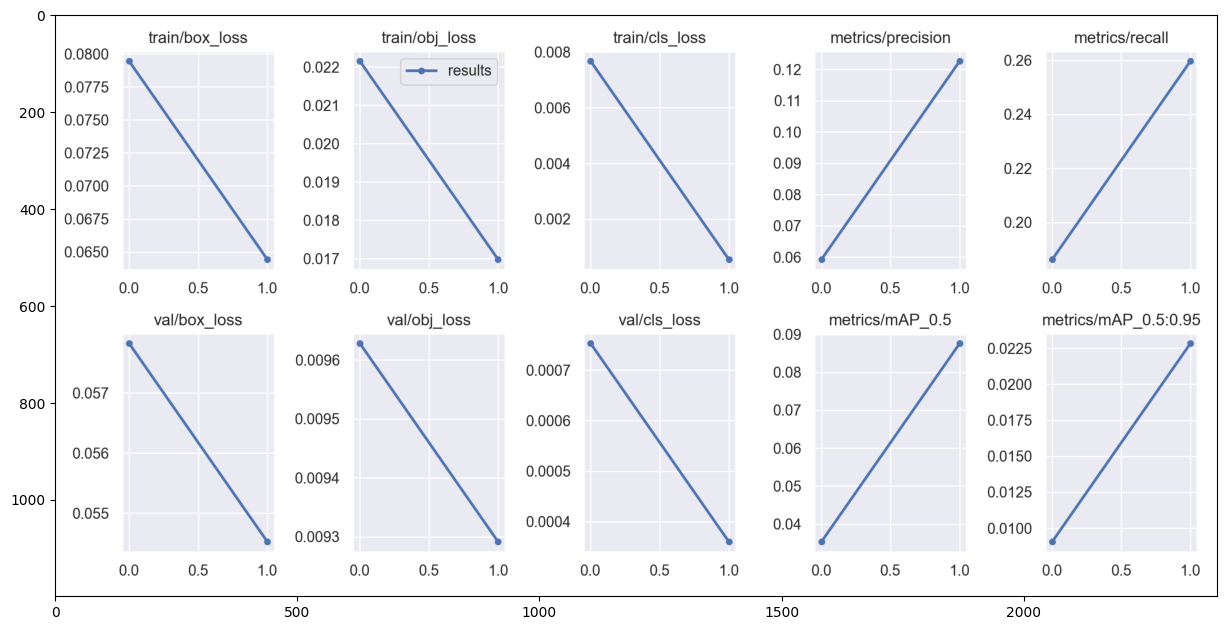

In [91]:
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/results.png'))

## Get the best mAP and best epoch

In [69]:
!ls

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
base_dir	 data	     models	   requirements.txt  tutorial.ipynb
benchmarks.py	 detect.py   my_data.yaml  runs		     utils
CITATION.cff	 export.py   my_hyp.yaml   segment	     val.py
classify	 hubconf.py  __pycache__   setup.cfg	     yolov5s.pt
CONTRIBUTING.md  LICENSE     README.md	   train.py


In [74]:
# Display the contents of the results.txt file

path = f'/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/{exp}/results.csv'

!cat $path

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
               epoch,      train/box_loss,      train/obj_loss,      train/cls_loss,   metrics/precision,      metrics/recall,     metrics/mAP_0.5,metrics/mAP_0.5:0.95,        val/box_loss,        val/obj_loss,        val/cls_loss,               x/lr0,               x/lr1,               x/lr2
                   0,            0.079454,            0.022152,           0.0076706,            0.059236,             0.18629,            0.035335,           0.0090567,            0.057823,           0.0096279,          0.00075258,            0.070036,           0.0033293,           0.0033293
                   1,            0.064425,            0.016974,          0.00055042,             0.12264,              0.2597,            0.087602,            0.022835,            0.054524,           0.0092914,          0.00036036,            0.036739,           0.0033646,      

In [75]:
# Read the results from the training log: results.txt

# https://stackoverflow.com/questions/3277503/how-to-read-a-file-line-by-line-into-a-list
# https://stackoverflow.com/questions/65381312/how-to-convert-a-yolo-darknet-format-into-csv-file


filename = f'/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/{exp}/results.csv'

file_list = []

with open(filename) as f:
    # read a line into a list, format: ['item item item', 'item item item', ...]
    file_line_list = f.readlines()
    
    
for i in range(0, len(file_line_list)):
    
    # Get the first item in the list and split on the spaces.
    # This returns a list of all items in the line: ['item', 'item', 'item']
    line_list = file_line_list[i].split()
    
    # remove whitespace characters like `\n` at the end of each line
    line_list = [x.strip() for x in line_list]
    
    # Save the list.
    # all_lines_list is a list of lists
    file_list.append(line_list)
    
len(file_list)

3

In [76]:
# Put the file data into a dataframe

df = pd.DataFrame(file_list)

df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,"epoch,","train/box_loss,","train/obj_loss,","train/cls_loss,","metrics/precision,","metrics/recall,","metrics/mAP_0.5,metrics/mAP_0.5:0.95,","val/box_loss,","val/obj_loss,","val/cls_loss,","x/lr0,","x/lr1,",x/lr2,None
1,"0,","0.079454,","0.022152,","0.0076706,","0.059236,","0.18629,","0.035335,","0.0090567,","0.057823,","0.0096279,","0.00075258,","0.070036,","0.0033293,",0.0033293
2,"1,","0.064425,","0.016974,","0.00055042,","0.12264,","0.2597,","0.087602,","0.022835,","0.054524,","0.0092914,","0.00036036,","0.036739,","0.0033646,",0.0033646


In [77]:
# choose only the columns we want

col_names = ['epoch', 'P', 'R', 'map0.5', 'map0.5:0.95']

# filter out specific columns
df_results = df[[0, 8, 9, 10, 11]]

df_results.columns = col_names

# change the column names
df_results.head(10)

,epoch,P,R,map0.5,map0.5:0.95
0,"epoch,","val/obj_loss,","val/cls_loss,","x/lr0,","x/lr1,"
1,"0,","0.057823,","0.0096279,","0.00075258,","0.070036,"
2,"1,","0.054524,","0.0092914,","0.00036036,","0.036739,"


In [78]:
# Get the best map0.5

best_map = df_results['map0.5'].max()

print('---------------------')

print('Best map0.5:', best_map)
print()

# print the row that contains the best map0.5
df = df_results[df_results['map0.5'] == best_map]

print(df.head())

print('---------------------')

---------------------
Best map0.5: x/lr0,

    epoch              P              R  map0.5 map0.5:0.95
0  epoch,  val/obj_loss,  val/cls_loss,  x/lr0,      x/lr1,
---------------------


## Display one batch of train images

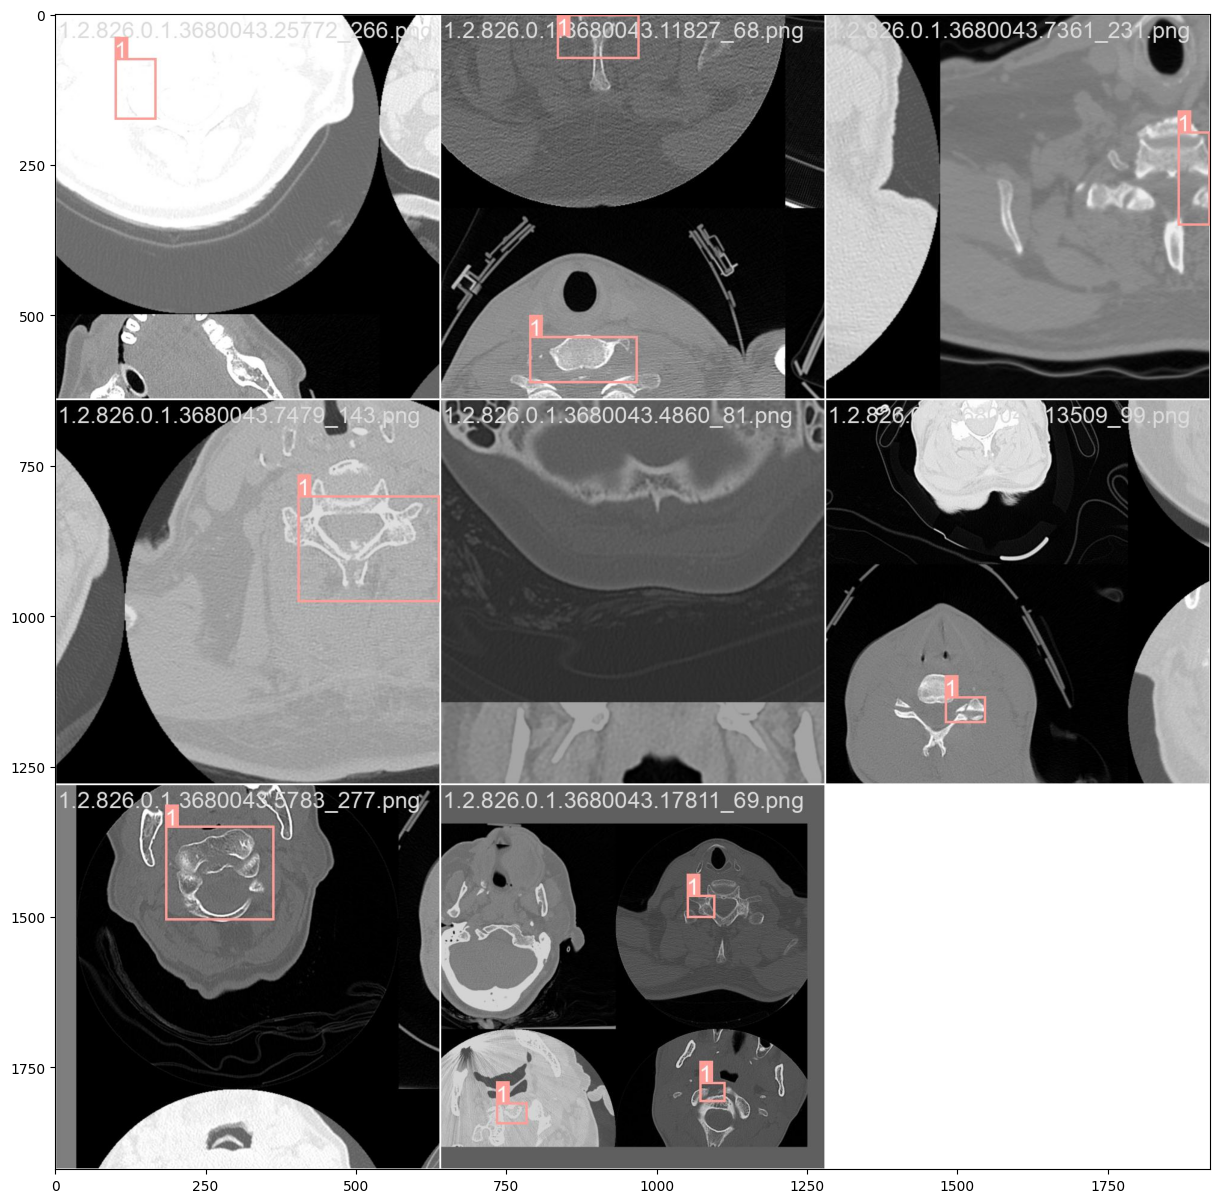

In [82]:
# Train
# One mosaic batch of train images with labels

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/{exp}/train_batch0.jpg'))

## Display true and predicted val set bboxes

Here we will display the true and predicted bboxes for two val batches.

In [92]:
# BATCH 0 - TRUE BBOXES

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/{exp}/test_batch0_labels.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/my_model/test_batch0_labels.jpg'

<Figure size 1500x1500 with 0 Axes>

In [84]:
# BATCH 0 - PREDICTED BBOXES

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'/home/nvr5386/Desktop/RSNA/project_data/yolov5/runs/train/{exp}/test_batch0_pred.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: 'runs/train/my_model/test_batch0_pred.jpg'

<Figure size 1500x1500 with 0 Axes>

In [ ]:
# BATCH 1 - TRUE BBOXES

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/test_batch1_labels.jpg'))

In [ ]:
# BATCH 1 - PREDICTED BBOXES

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/test_batch1_pred.jpg'))

## Make a prediction on the val set

In [93]:
# change the working directory
os.chdir('/home/nvr5386/Desktop/RSNA/project_data/')

!pwd

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/nvr5386/Desktop/RSNA/project_data


In [94]:
# Create a folder to store the extracted files
if os.path.isdir('yolo_images_dir') == False:
    yolo_images_dir = 'yolo_images_dir'
    os.mkdir(yolo_images_dir)
    
    
    
val_fname_list = list(df_val['study_slice'])

for study_slice in val_fname_list:
    
    fname = study_slice + '.png'
    
    # Copy the image to images
    # Set the path to the images here.
    shutil.copyfile(
        f"{prep_data_path}/images_dir/{fname}",
        f"yolo_images_dir/{fname}")
    
    
len(os.listdir('yolo_images_dir'))

1644

In [95]:
!ls

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
archive.zip
best.pt
df_data.csv
image.png
images_dir
models
nohup.out
pytorch-effnetv2-vertebrae-detection-acc-0-95.ipynb
RSNA
rsna-fracture-detection-in-depth-eda.ipynb
segeffnetv2-f0
submission.csv
testmodel.tph
yolo_images_dir
yolov5
yolov5-cervical-spine-neck-fracture-detection.ipynb


In [96]:
# change the working directory
os.chdir('/home/nvr5386/Desktop/RSNA/project_data/yolov5')

!pwd

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/nvr5386/Desktop/RSNA/project_data/yolov5


In [98]:
# Make a prediction on all images in images_dir

# The model only creates a txt file if it finds objects on an image.

test_images_path = '/home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir'
yolo_model_path = '/home/nvr5386/Desktop/RSNA/project_data/best.pt'

# Ensembling two Yolo models
# How to ensemble Yolov5 models:
# Ref: https://github.com/ultralytics/yolov5/issues/318

!python detect.py --source $test_images_path --weights $yolo_model_path --img $IMAGE_SIZE --save-txt --save-conf --exist-ok

/bin/bash: /home/nvr5386/miniconda3/envs/machinelearning/lib/libtinfo.so.6: no version information available (required by /bin/bash)
detect: weights=['/home/nvr5386/Desktop/RSNA/project_data/best.pt'], source=/home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-27-g454dae1 Python-3.9.12 torch-1.12.1+cu102 CUDA:0 (Quadro RTX 6000, 24198MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.10051_116.png: 512x512 (no detections), 7.9ms
image 2/1644 /home/n

image 56/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.11401_90.png: 512x512 (no detections), 7.2ms
image 57/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.11401_98.png: 512x512 (no detections), 8.9ms
image 58/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.1151_305.png: 512x512 (no detections), 8.1ms
image 59/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.1151_308.png: 512x512 (no detections), 9.2ms
image 60/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.1151_538.png: 512x512 (no detections), 7.8ms
image 61/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.11644_199.png: 512x512 (no detections), 7.7ms
image 62/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.11644_204.png: 512x512 (no detections), 11.5ms
image 63/1644 /home/nvr5386/Desktop/RSNA/project_dat

image 117/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.12328_205.png: 512x512 (no detections), 7.7ms
image 118/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.12328_212.png: 512x512 (no detections), 5.9ms
image 119/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.12351_202.png: 512x512 (no detections), 6.0ms
image 120/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.12351_460.png: 512x512 (no detections), 8.5ms
image 121/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.12395_244.png: 512x512 (no detections), 7.6ms
image 122/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.12395_296.png: 512x512 (no detections), 10.4ms
image 123/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.12453_213.png: 512x512 (no detections), 8.8ms
image 124/1644 /home/nvr5386/Desktop/RSN

image 177/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.13203_199.png: 512x512 (no detections), 9.7ms
image 178/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.13203_82.png: 512x512 (no detections), 8.5ms
image 179/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.13203_83.png: 512x512 (no detections), 7.5ms
image 180/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.13203_86.png: 512x512 (no detections), 8.7ms
image 181/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.13337_214.png: 512x512 (no detections), 10.7ms
image 182/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.13360_67.png: 512x512 (no detections), 7.7ms
image 183/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.13360_72.png: 512x512 (no detections), 5.3ms
image 184/1644 /home/nvr5386/Desktop/RSNA/pro

image 237/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.14267_296.png: 512x512 (no detections), 9.2ms
image 238/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.14360_144.png: 512x512 (no detections), 8.3ms
image 239/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.14360_150.png: 512x512 (no detections), 9.4ms
image 240/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.1443_51.png: 512x512 (no detections), 8.9ms
image 241/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.14615_34.png: 512x512 (no detections), 8.0ms
image 242/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.14615_36.png: 512x512 (no detections), 8.9ms
image 243/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.14615_38.png: 512x512 (no detections), 5.9ms
image 244/1644 /home/nvr5386/Desktop/RSNA/proj

image 298/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.15840_76.png: 512x512 (no detections), 10.2ms
image 299/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.15857_133.png: 512x512 (no detections), 3.8ms
image 300/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.15857_137.png: 512x512 (no detections), 4.5ms
image 301/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.15857_140.png: 512x512 (no detections), 7.2ms
image 302/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.15857_144.png: 512x512 (no detections), 8.1ms
image 303/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.15857_146.png: 512x512 (no detections), 8.5ms
image 304/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.15857_148.png: 512x512 (no detections), 8.4ms
image 305/1644 /home/nvr5386/Desktop/RSNA

image 358/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.16838_177.png: 512x512 (no detections), 8.8ms
image 359/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.16838_181.png: 512x512 (no detections), 6.4ms
image 360/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.16919_224.png: 512x512 (no detections), 5.8ms
image 361/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.16935_118.png: 512x512 (no detections), 6.6ms
image 362/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.17052_299.png: 512x512 (no detections), 8.0ms
image 363/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.17052_300.png: 512x512 (no detections), 10.2ms
image 364/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.17052_301.png: 512x512 (no detections), 8.9ms
image 365/1644 /home/nvr5386/Desktop/RSN

image 418/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.17884_171.png: 512x512 (no detections), 6.0ms
image 419/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.18077_186.png: 512x512 (no detections), 7.2ms
image 420/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.18077_190.png: 512x512 (no detections), 6.4ms
image 421/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.18141_248.png: 512x512 (no detections), 7.4ms
image 422/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.18141_252.png: 512x512 (no detections), 7.0ms
image 423/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.18141_254.png: 512x512 (no detections), 8.4ms
image 424/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.18576_142.png: 512x512 (no detections), 8.1ms
image 425/1644 /home/nvr5386/Desktop/RSNA

image 478/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.19778_259.png: 512x512 (no detections), 9.4ms
image 479/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.19778_260.png: 512x512 (no detections), 8.7ms
image 480/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.19778_265.png: 512x512 (no detections), 8.0ms
image 481/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.19778_273.png: 512x512 (no detections), 8.2ms
image 482/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.19778_274.png: 512x512 (no detections), 8.3ms
image 483/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.19778_305.png: 512x512 (no detections), 5.9ms
image 484/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.19778_307.png: 512x512 (no detections), 8.2ms
image 485/1644 /home/nvr5386/Desktop/RSNA

image 538/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.20727_637.png: 512x512 (no detections), 3.8ms
image 539/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.20773_148.png: 512x512 (no detections), 10.0ms
image 540/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.20773_150.png: 512x512 (no detections), 7.5ms
image 541/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.20773_151.png: 512x512 (no detections), 8.6ms
image 542/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.20773_154.png: 512x512 (no detections), 6.0ms
image 543/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.20773_157.png: 512x512 (no detections), 7.4ms
image 544/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.20773_43.png: 512x512 (no detections), 9.1ms
image 545/1644 /home/nvr5386/Desktop/RSNA

image 598/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.21586_72.png: 512x512 (no detections), 7.8ms
image 599/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.21651_167.png: 512x512 (no detections), 6.9ms
image 600/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.21651_171.png: 512x512 (no detections), 8.1ms
image 601/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.21651_175.png: 512x512 (no detections), 7.8ms
image 602/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.21651_180.png: 512x512 (no detections), 10.9ms
image 603/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.21651_185.png: 512x512 (no detections), 6.1ms
image 604/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.21651_187.png: 512x512 (no detections), 8.1ms
image 605/1644 /home/nvr5386/Desktop/RSNA

image 658/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.22543_87.png: 512x512 (no detections), 10.3ms
image 659/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.22548_207.png: 512x512 (no detections), 7.7ms
image 660/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.22548_213.png: 512x512 (no detections), 10.2ms
image 661/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.22548_228.png: 512x512 (no detections), 11.0ms
image 662/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.22548_229.png: 512x512 (no detections), 8.1ms
image 663/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.22548_230.png: 512x512 (no detections), 5.6ms
image 664/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.22548_232.png: 512x512 (no detections), 7.8ms
image 665/1644 /home/nvr5386/Desktop/RS

image 718/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.23817_66.png: 512x512 (no detections), 7.7ms
image 719/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.23817_71.png: 512x512 (no detections), 5.5ms
image 720/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.23888_36.png: 512x512 (no detections), 10.7ms
image 721/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.23888_53.png: 512x512 (no detections), 5.6ms
image 722/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.23888_54.png: 512x512 (no detections), 8.2ms
image 723/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.23888_58.png: 512x512 (no detections), 8.5ms
image 724/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.23904_153.png: 512x512 (no detections), 10.5ms
image 725/1644 /home/nvr5386/Desktop/RSNA/pro

image 778/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25238_105.png: 512x512 (no detections), 6.7ms
image 779/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25238_107.png: 512x512 (no detections), 7.1ms
image 780/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25238_136.png: 512x512 (no detections), 4.0ms
image 781/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25238_149.png: 512x512 (no detections), 7.2ms
image 782/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25238_151.png: 512x512 (no detections), 7.8ms
image 783/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25238_152.png: 512x512 (no detections), 8.2ms
image 784/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25238_170.png: 512x512 (no detections), 8.6ms
image 785/1644 /home/nvr5386/Desktop/RSNA

image 838/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25772_382.png: 512x512 (no detections), 8.8ms
image 839/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25772_386.png: 512x512 (no detections), 8.3ms
image 840/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25772_388.png: 512x512 (no detections), 8.1ms
image 841/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25772_401.png: 512x512 (no detections), 8.3ms
image 842/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25772_403.png: 512x512 (no detections), 8.2ms
image 843/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25772_412.png: 512x512 (no detections), 8.1ms
image 844/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.25772_414.png: 512x512 (no detections), 9.7ms
image 845/1644 /home/nvr5386/Desktop/RSNA

image 898/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.26498_160.png: 512x512 (no detections), 8.6ms
image 899/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.26498_165.png: 512x512 (no detections), 5.8ms
image 900/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.26498_169.png: 512x512 (no detections), 5.8ms
image 901/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.26498_176.png: 512x512 (no detections), 8.4ms
image 902/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.26498_177.png: 512x512 (no detections), 8.7ms
image 903/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.26498_182.png: 512x512 (no detections), 12.5ms
image 904/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.26498_187.png: 512x512 (no detections), 8.6ms
image 905/1644 /home/nvr5386/Desktop/RSN

image 958/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.27714_141.png: 512x512 (no detections), 10.0ms
image 959/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.27714_147.png: 512x512 (no detections), 8.7ms
image 960/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.27714_150.png: 512x512 (no detections), 8.9ms
image 961/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.27714_81.png: 512x512 (no detections), 8.5ms
image 962/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.27714_82.png: 512x512 (no detections), 8.3ms
image 963/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.27714_91.png: 512x512 (no detections), 8.5ms
image 964/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.27714_92.png: 512x512 (no detections), 8.0ms
image 965/1644 /home/nvr5386/Desktop/RSNA/pr

image 1018/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.28913_257.png: 512x512 (no detections), 8.8ms
image 1019/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.29015_92.png: 512x512 (no detections), 7.9ms
image 1020/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.29047_100.png: 512x512 (no detections), 7.6ms
image 1021/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.29047_101.png: 512x512 (no detections), 8.0ms
image 1022/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.29047_103.png: 512x512 (no detections), 8.7ms
image 1023/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.29142_183.png: 512x512 (no detections), 8.8ms
image 1024/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.29142_194.png: 512x512 (no detections), 9.5ms
image 1025/1644 /home/nvr5386/Deskt

image 1078/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.29949_62.png: 512x512 (no detections), 10.8ms
image 1079/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.29968_109.png: 512x512 (no detections), 10.2ms
image 1080/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.2998_183.png: 512x512 (no detections), 8.5ms
image 1081/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.2998_184.png: 512x512 (no detections), 8.3ms
image 1082/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.2998_185.png: 512x512 (no detections), 9.3ms
image 1083/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.2998_187.png: 512x512 (no detections), 7.9ms
image 1084/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.2998_189.png: 512x512 (no detections), 9.5ms
image 1085/1644 /home/nvr5386/Desktop/

image 1138/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.30549_55.png: 512x512 (no detections), 8.7ms
image 1139/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.30549_59.png: 512x512 (no detections), 8.7ms
image 1140/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.30549_61.png: 512x512 (no detections), 8.5ms
image 1141/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.30640_159.png: 512x512 (no detections), 7.7ms
image 1142/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.30640_166.png: 512x512 (no detections), 7.9ms
image 1143/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.30640_171.png: 512x512 (no detections), 8.7ms
image 1144/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.30708_46.png: 512x512 (no detections), 9.6ms
image 1145/1644 /home/nvr5386/Desktop/

image 1198/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.31077_309.png: 512x512 (no detections), 7.5ms
image 1199/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.31077_311.png: 512x512 (no detections), 8.2ms
image 1200/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.31077_315.png: 512x512 (no detections), 8.9ms
image 1201/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.31077_316.png: 512x512 (no detections), 7.7ms
image 1202/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.31077_318.png: 512x512 (no detections), 9.1ms
image 1203/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.31077_319.png: 512x512 (no detections), 8.8ms
image 1204/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.31077_321.png: 512x512 (no detections), 8.0ms
image 1205/1644 /home/nvr5386/Desk

image 1258/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.32426_252.png: 512x512 (no detections), 4.6ms
image 1259/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.32436_119.png: 512x512 (no detections), 4.1ms
image 1260/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.32651_134.png: 512x512 (no detections), 3.4ms
image 1261/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.32651_141.png: 512x512 (no detections), 9.5ms
image 1262/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.32651_144.png: 512x512 (no detections), 8.5ms
image 1263/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.32651_147.png: 512x512 (no detections), 8.4ms
image 1264/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.32692_100.png: 512x512 (no detections), 8.9ms
image 1265/1644 /home/nvr5386/Desk

image 1318/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.3882_91.png: 512x512 (no detections), 5.4ms
image 1319/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.3882_92.png: 512x512 (no detections), 6.7ms
image 1320/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.3882_96.png: 512x512 (no detections), 7.6ms
image 1321/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.3887_268.png: 512x512 (no detections), 7.8ms
image 1322/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.3887_302.png: 512x512 (no detections), 9.0ms
image 1323/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.3887_307.png: 512x512 (no detections), 9.5ms
image 1324/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.4110_238.png: 512x512 (no detections), 5.3ms
image 1325/1644 /home/nvr5386/Desktop/RSNA/p

image 1378/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.4691_169.png: 512x512 (no detections), 7.8ms
image 1379/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.4716_32.png: 512x512 (no detections), 6.1ms
image 1380/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.4740_102.png: 512x512 (no detections), 10.6ms
image 1381/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.4740_104.png: 512x512 (no detections), 9.6ms
image 1382/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.4740_107.png: 512x512 (no detections), 8.9ms
image 1383/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.4740_108.png: 512x512 (no detections), 8.3ms
image 1384/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.4740_112.png: 512x512 (no detections), 8.4ms
image 1385/1644 /home/nvr5386/Desktop/RSN

image 1438/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.5572_118.png: 512x512 (no detections), 5.8ms
image 1439/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.5572_125.png: 512x512 (no detections), 10.7ms
image 1440/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.5572_129.png: 512x512 (no detections), 9.0ms
image 1441/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.5572_132.png: 512x512 (no detections), 6.3ms
image 1442/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.5572_134.png: 512x512 (no detections), 8.8ms
image 1443/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.5572_142.png: 512x512 (no detections), 7.7ms
image 1444/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.5572_146.png: 512x512 (no detections), 8.9ms
image 1445/1644 /home/nvr5386/Desktop/RS

image 1498/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.5949_129.png: 512x512 (no detections), 5.2ms
image 1499/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.601_155.png: 512x512 (no detections), 7.7ms
image 1500/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.601_164.png: 512x512 (no detections), 4.9ms
image 1501/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.6225_144.png: 512x512 (no detections), 6.9ms
image 1502/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.6225_145.png: 512x512 (no detections), 8.5ms
image 1503/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.6225_146.png: 512x512 (no detections), 7.7ms
image 1504/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.6225_147.png: 512x512 (no detections), 8.3ms
image 1505/1644 /home/nvr5386/Desktop/RSNA/

image 1558/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.7351_388.png: 512x512 (no detections), 8.5ms
image 1559/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.7351_395.png: 512x512 (no detections), 7.1ms
image 1560/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.7351_396.png: 512x512 (no detections), 9.4ms
image 1561/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.7361_217.png: 512x512 (no detections), 8.2ms
image 1562/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.7361_228.png: 512x512 (no detections), 6.5ms
image 1563/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.7408_40.png: 512x512 (no detections), 9.2ms
image 1564/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.7479_125.png: 512x512 (no detections), 6.0ms
image 1565/1644 /home/nvr5386/Desktop/RSNA

image 1618/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.8693_48.png: 512x512 (no detections), 9.2ms
image 1619/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.8731_178.png: 512x512 (no detections), 9.0ms
image 1620/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.8759_138.png: 512x512 (no detections), 7.5ms
image 1621/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.8820_70.png: 512x512 (no detections), 8.4ms
image 1622/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.8907_215.png: 512x512 (no detections), 10.8ms
image 1623/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.8935_290.png: 512x512 (no detections), 9.1ms
image 1624/1644 /home/nvr5386/Desktop/RSNA/project_data/yolo_images_dir/1.2.826.0.1.3680043.8942_3.png: 512x512 (no detections), 7.7ms
image 1625/1644 /home/nvr5386/Desktop/RSNA/p

## Process the predictions

In [ ]:
txt_files_list = os.listdir('runs/detect/exp/labels')

print(len(txt_files_list))
print(txt_files_list[0])

In [ ]:
# Put the info inside all the txt files into one dataframe.
# Remember that if the image does not have any bounding boxes
# then Yolo does not create a txt file for it.

txt_files_list = os.listdir('runs/detect/exp/labels')

for i, txt_file in enumerate(txt_files_list):
    
    # set the path
    path = f'runs/detect/exp/labels/{txt_file}'
    
    # create a list of column names
    cols = ['class', 'x-center', 'y-center', 'bbox_width', 'bbox_height', 'conf-score']

    # put the file contents into a dataframe
    df = pd.read_csv(path, sep=" ", header=None)
    
    # add the column names to the datafrae
    df.columns = cols
    
    # Split the txt fname on the full stop and choose the first item 
    # in the list. The add the .jpg extension.
    # 87a0829f53c1.txt becomes 87a0829f53c1_image
    #fname = txt_file.split('.')[0] + '.png'
    fname = txt_file.replace("txt", "png")
    
    # add a new column with the fname
    df['id'] = fname
 
    # stack the dataframes for each txt file
    if i == 0:
        
        df_test_preds = df
    else:
        
        df_test_preds = pd.concat([df_test_preds, df], axis=0)
       
    
    
print(len(txt_files_list))
print(df_test_preds['id'].nunique())
print(df_test_preds.shape)

df_test_preds.head()

In [ ]:
# Add the predictions to df_val

# reset the index
df_val = df_val.reset_index(drop=True)

# create a new column called 'id'
df_val['id'] =  df_val['study_slice'] + '.png'

val_pred_list = []

pred_list = list(df_test_preds['id'])

for i in range(0, len(df_val)):
    
    #fname = df_val.loc[i, 'study_slice']
    #fname = study_slice + '.png'
    
    # get the fname
    fname = df_val.loc[i, 'id']
    
    # The fname will only be in the pred list if Yolo created a txt file for the val image.
    # Yolo will only create a txt file if a fracture was detected on the image.
    if fname in pred_list:
        
        val_pred_list.append(1)
    else:
        val_pred_list.append(0)
    
    
df_val['preds'] = val_pred_list

# Check the distribution of the predicted classes
df_val['preds'].value_counts()

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

CLASS_LIST = ['Normal', 'Fracture']
    
# targets
y_true = list(df_val['target'])

# get the preds as integers
y_pred = list(df_val['preds'])

# argmax returns the index of the max value in each row.
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix.
print()
print(cm)
print(CLASS_LIST)

In [ ]:
cm_plot_labels = ['normal', 'fracture']

# Set the size of the plot.
#plt.figure(figsize=(10,7))

# Set the size of the text
text_size=12

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', text_size=text_size)

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
    
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print()
print(report)

### Precision

Given a prediction, what is the probability that the prediction is correct. In other words, how much can we trust a prediction made by the model?

### Recall

What percentage of the total number of objects did the model detect? Given an object, what is the probability that the model will detect it? Example: Did the computer vision model in the self driving car detect all the pedestrians?

## Delete images to prevent notebook commit errors

In [ ]:
# change the working directory to yolov5

os.chdir('/kaggle/working/yolov5')

!pwd

In [ ]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('base_dir') == True:
    shutil.rmtree('base_dir')

In [ ]:
# change the working directory

os.chdir('/kaggle/working/')

!pwd

In [ ]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('images_dir') == True:
    shutil.rmtree('images_dir')
    
if os.path.isdir('val_images_dir') == True:
    shutil.rmtree('val_images_dir')

In [ ]:
!ls